In [ ]:
# Shai Rashada-Parasram.
# 4/22/25
# Data Household energy project for MSIS 415.

# Description of the project: This Python script analyzes household electric power consumption data from a dataset covering nearly four years with one-minute sampling. 
# It performs exploratory data analysis (EDA) using Pandas and Matplotlib to examine energy usage patterns, focusing on global active power and sub-metering values. 
# The code cleans the dataset by handling missing values, converts time-series data for analysis, and visualizes trends through plots like daily and monthly energy consumption. 
# It also applies statistical methods to identify correlations and anomalies, supporting regression and clustering tasks for energy optimization insights.


# Importing necessary libraries and suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Use Agg for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

%matplotlib inline

# Set seaborn style for better aesthetics
sns.set(style='whitegrid', palette='muted')

In [2]:
# Loading the dataset
data_path = '/kaggle/input/household-energy-consumption/household_energy_consumption.csv'
df = pd.read_csv(data_path, delimiter=',', encoding='ascii')

# Display the first few rows
df.head()

,Household_ID,Date,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Has_AC,Peak_Hours_Usage_kWh
0,H00001,2025-04-01,8.4,4,17.8,No,3.2
1,H00001,2025-04-02,7.9,4,17.3,No,2.8
2,H00001,2025-04-03,9.2,4,18.6,No,3.0
3,H00001,2025-04-04,7.9,4,18.2,No,2.7
4,H00001,2025-04-05,9.6,4,11.9,No,3.2


In [3]:
# Quick dataset exploration
print('Dataset shape:', df.shape)
print('Data types:')
print(df.dtypes)

# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())

Dataset shape: (90000, 7)
Data types:
Household_ID               object
Date                       object
Energy_Consumption_kWh    float64
Household_Size              int64
Avg_Temperature_C         float64
Has_AC                     object
Peak_Hours_Usage_kWh      float64
dtype: object
Missing values per column:
Household_ID              0
Date                      0
Energy_Consumption_kWh    0
Household_Size            0
Avg_Temperature_C         0
Has_AC                    0
Peak_Hours_Usage_kWh      0
dtype: int64


In [4]:
# Converting the 'Date' column from string to datetime
try:
    df['Date'] = pd.to_datetime(df['Date'])
except Exception as e:
    print('Error converting Date column:', e)
    # This error handling is important if others encounter non-standard date formats

# Convert 'Has_AC' to a categorical binary variable
df['Has_AC'] = df['Has_AC'].map({'Yes': 1, 'No': 0})

# If there are any missing values in key columns, fill them appropriately
df.fillna(method='ffill', inplace=True)

# Display summary statistics after cleaning
df.describe(include='all')

,Household_ID,Date,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Has_AC,Peak_Hours_Usage_kWh
count,90000,90000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
unique,12857,NaN,NaN,NaN,NaN,NaN,NaN
top,H12857,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2025-04-04 00:00:03.839999744,10.571988,3.487811,17.505802,0.494356,4.319557
min,NaN,2025-04-01 00:00:00,0.500000,1.000000,10.000000,0.000000,0.200000
25%,NaN,2025-04-02 00:00:00,6.000000,2.000000,15.800000,0.000000,2.300000
50%,NaN,2025-04-04 00:00:00,10.400000,3.000000,17.500000,0.000000,4.000000
75%,NaN,2025-04-06 00:00:00,14.800000,5.000000,19.200000,1.000000,6.000000
max,NaN,2025-04-08 00:00:00,20.000000,6.000000,25.000000,1.000000,10.000000


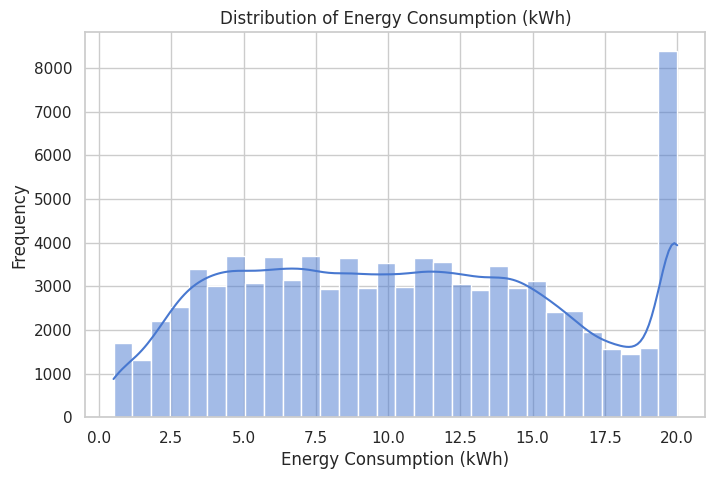

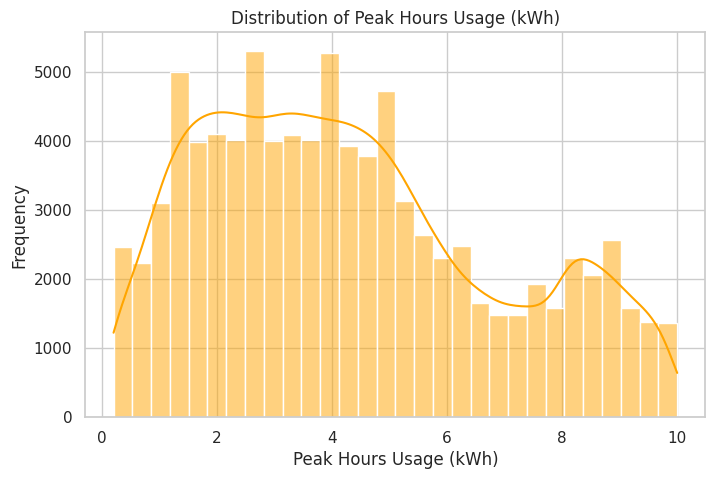

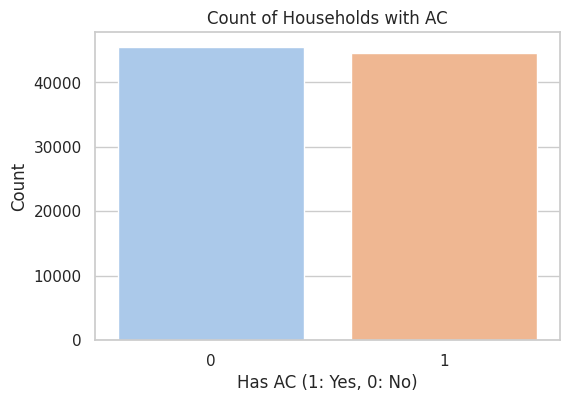

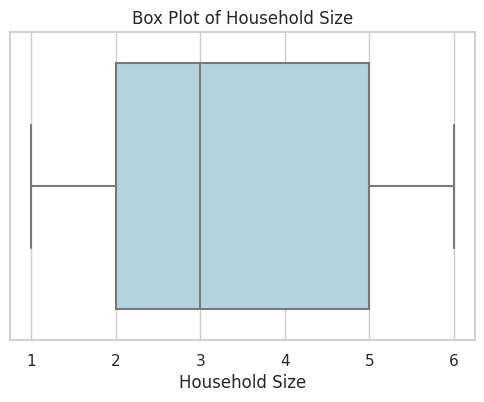

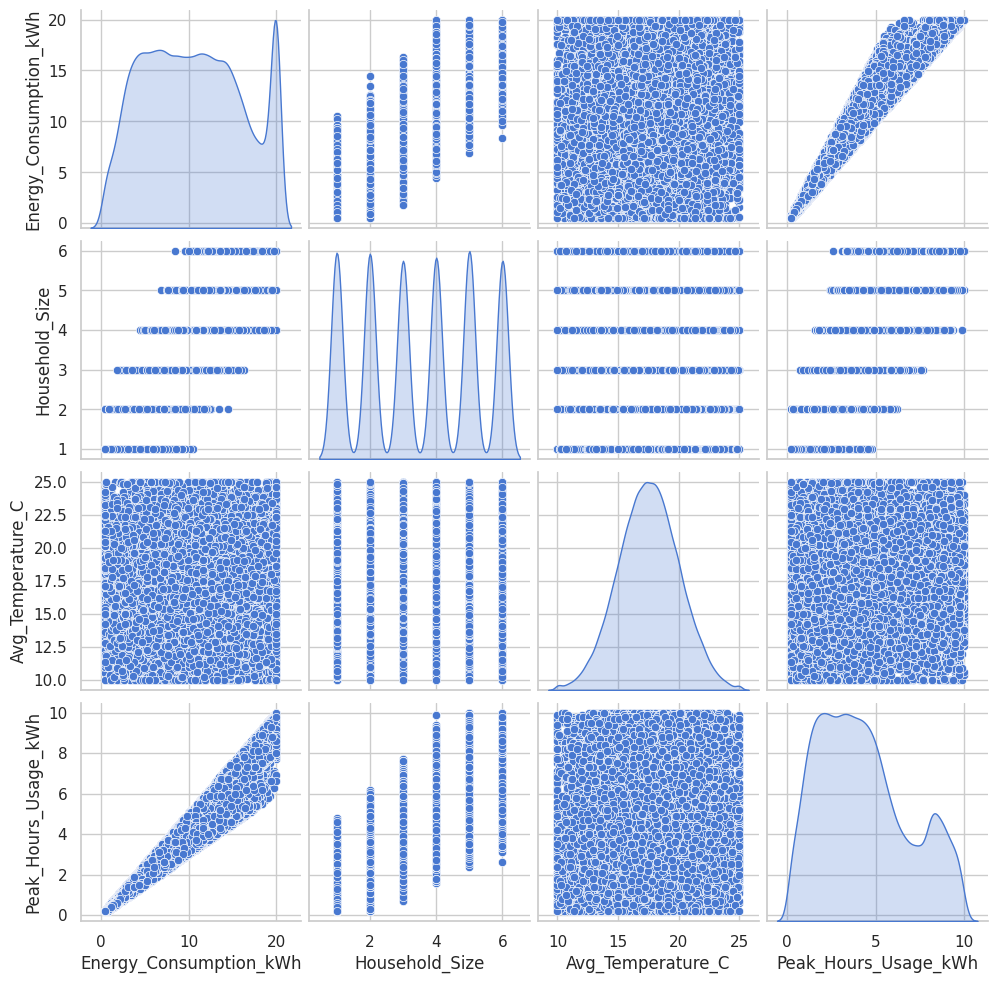

In [5]:
# Histogram for Energy Consumption
plt.figure(figsize=(8, 5))
sns.histplot(df['Energy_Consumption_kWh'], kde=True, bins=30)
plt.title('Distribution of Energy Consumption (kWh)')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

# Histogram for Peak Hours Usage
plt.figure(figsize=(8, 5))
sns.histplot(df['Peak_Hours_Usage_kWh'], kde=True, bins=30, color='orange')
plt.title('Distribution of Peak Hours Usage (kWh)')
plt.xlabel('Peak Hours Usage (kWh)')
plt.ylabel('Frequency')
plt.show()

# Countplot for Has_AC (Pie chart alternative)
plt.figure(figsize=(6, 4))
sns.countplot(x='Has_AC', data=df, palette='pastel')
plt.title('Count of Households with AC')
plt.xlabel('Has AC (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

# Box Plot for Household Size
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Household_Size'], color='lightblue')
plt.title('Box Plot of Household Size')
plt.xlabel('Household Size')
plt.show()

# Pair Plot for selected numeric variables to explore pairwise relationships
numeric_columns = ['Energy_Consumption_kWh', 'Household_Size', 'Avg_Temperature_C', 'Peak_Hours_Usage_kWh']
sns.pairplot(df[numeric_columns], diag_kind='kde')
plt.show()

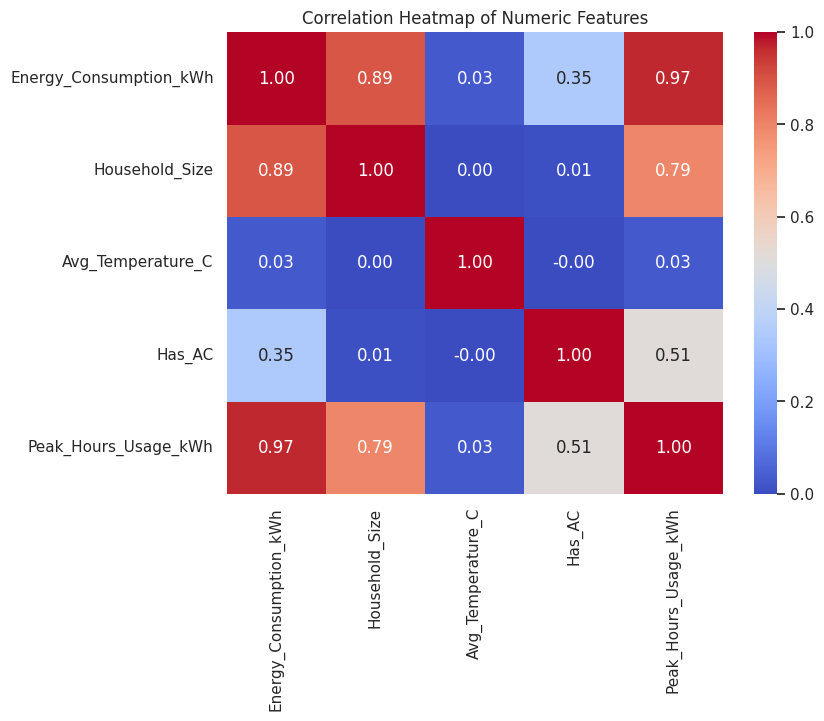

In [6]:
# Selecting only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Only show heatmap if there are at least four numeric columns
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8,6))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

R2 Score: 0.9727709375992287
RMSE: 0.4172158007884369


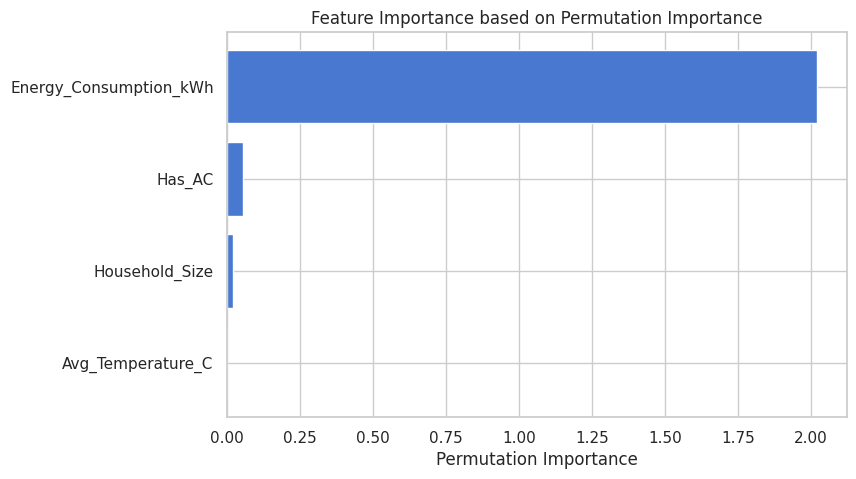

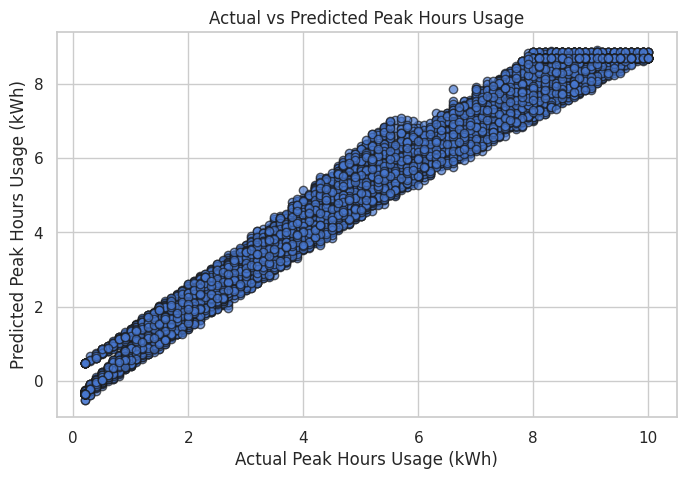

In [7]:
# For prediction, we'll predict 'Peak_Hours_Usage_kWh'
target = 'Peak_Hours_Usage_kWh'

# Selecting predictor features. We will use numeric predictors and the binary 'Has_AC'
features = ['Energy_Consumption_kWh', 'Household_Size', 'Avg_Temperature_C', 'Has_AC']

X = df[features]
y = df[target]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using R2 score and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('R2 Score:', r2)
print('RMSE:', rmse)

# Permutation Importance to see the impact of each feature
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance based on Permutation Importance')
plt.show()

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.xlabel('Actual Peak Hours Usage (kWh)')
plt.ylabel('Predicted Peak Hours Usage (kWh)')
plt.title('Actual vs Predicted Peak Hours Usage')
plt.show()